<a href="https://colab.research.google.com/github/vicmcl/deeplearwing/blob/main/deeplearwing/notebook/training2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import glob

In [3]:
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "deeplearwing"

Mounted at /content/drive


In [4]:
!git clone https://github.com/vicmcl/deeplearwing.git

fatal: destination path 'deeplearwing' already exists and is not an empty directory.


In [5]:
DATASET = "victorienmichel/deeplearwing"
CONTENT_PATH = Path('/content')
PROJECT_PATH = CONTENT_PATH / 'deeplearwing'
DATA_PATH = PROJECT_PATH / 'data'
ZIP_FILE = DATASET.split('/')[-1].lower() + '.zip'

In [6]:
!cd {PROJECT_PATH} && git pull origin main
!cp -r {PROJECT_PATH / 'deeplearwing' / 'src'} {CONTENT_PATH}

From https://github.com/vicmcl/deeplearwing
 * branch            main       -> FETCH_HEAD
Already up to date.


In [7]:
if not os.path.exists(DATA_PATH):
    print(f'Creating {DATA_PATH}')
    os.makedirs(DATA_PATH)

if not glob.glob(str(DATA_PATH / '*.csv')):

    if not os.path.exists(PROJECT_PATH / ZIP_FILE):
        !kaggle datasets download -d {DATASET} -p {DATA_PATH}

In [8]:
!pip install -q aerosandbox

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from src.features import string_to_floats
from src.plot import airfoil_to_image
from src.curvature_heatmap import compute_curvature
from src.checkpoint import checkpoint

In [10]:
df_csv = pd.read_csv(DATA_PATH / 'DeepLearWing.csv')
df_csv.head()

,name,angle,reynolds,x_coords,y_coords,cd,cl,cm
0,2032c,-8.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09761,-0.1581,-0.0262
1,2032c,-8.50,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09468,-0.1536,-0.0262
2,2032c,-8.25,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10671,-0.2407,-0.0219
3,2032c,-8.00,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10247,-0.2303,-0.0213
4,2032c,-7.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09947,-0.2229,-0.0215


In [11]:
n_samples = 10_000
samples = df_csv.sample(n = n_samples, random_state = 42)

In [32]:
mms = MinMaxScaler()
df = samples.copy()

In [33]:
targets = ['cd', 'cl', 'cm']
df.loc[:, 'cd'] = df['cd'].apply(np.log)
df.loc[:, targets] = mms.fit_transform(df[targets])
df['target'] = df.apply(lambda row: [row[t] for t in targets], axis = 1)
df = df.drop(columns = targets)

In [34]:
df[['angle', 'reynolds']] = mms.fit_transform(samples[['angle', 'reynolds']])
df.loc[:, ['x_coords', 'y_coords']] = df[['x_coords', 'y_coords']].applymap(string_to_floats)

In [15]:
df.head()

,name,angle,reynolds,x_coords,y_coords,target
51063,fx84w127,0.823899,0.157895,"[1.0, 0.99893, 0.99572, 0.99039, 0.98296, 0.97...","[0.0, 0.00011, 0.0005, 0.0012, 0.0023, 0.00385...","[0.6113299968184446, 0.760406247595599, 0.4372..."
802509,s8052,0.308176,0.052632,"[1.0, 0.99803, 0.99231, 0.98301, 0.97022, 0.95...","[0.0, 0.00018, 0.00079, 0.00181, 0.0033, 0.005...","[0.6177742953448339, 0.28383473109179047, 0.41..."
419227,goe505,0.301887,0.000000,"[1.0, 0.94959, 0.89918, 0.7985, 0.69791, 0.597...","[0.0, 0.01784, 0.03568, 0.06537, 0.09105, 0.10...","[0.8125685123506596, 0.34741350568079815, 0.46..."
132195,npl9660,0.735849,0.157895,"[1.0, 0.997614, 0.990418, 0.9785, 0.961985, 0....","[0.0013, 0.001763, 0.002031, 0.002194, 0.00332...","[0.44704191223458734, 0.7069067220640661, 0.49..."
542560,fx78k161,0.213836,0.473684,"[1.0, 0.99893, 0.99572, 0.99039, 0.98296, 0.97...","[0.0, 0.00103, 0.00172, 0.00262, 0.00365, 0.00...","[0.5093686478665304, 0.2525967530968685, 0.355..."


In [35]:
import concurrent.futures

w = 256
h = 512

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures_shape = [executor.submit(airfoil_to_image, row['x_coords'], row['y_coords'], h, w) for _, row in df.iterrows()]
    results_shape = [future.result() for future in futures_shape]

In [36]:
from tqdm import tqdm
curvatures = [compute_curvature(img) for img in tqdm(results_shape)]

100%|██████████| 10000/10000 [03:39<00:00, 45.61it/s]


In [37]:
df['shape'] = results_shape
df['curvature'] = curvatures
df = df.drop(columns = ['x_coords', 'y_coords'])

In [62]:
df = df[~pd.isnull(df['curvature'])]
len(df)

9928

In [67]:
def image_generator(df, batch_size=32, h=h, w=w):
    num_samples = len(df)
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_df = df.iloc[start:end]

        combined_images = []
        indices = []

        for idx, row in batch_df.iterrows():
            channel1 = np.array(row['shape'], dtype=np.float32)
            channel2 = np.array(row['curvature'], dtype=np.float32)
            combined_image = np.stack([channel1, channel2], axis=-1)
            combined_images.append(combined_image)
            indices.append(idx)

        yield pd.DataFrame({'combined_image': combined_images}, index=indices)

In [68]:
images =  pd.DataFrame()
for batch in image_generator(df):
    images = pd.concat([images, batch])

In [69]:
df = pd.concat([df, images], axis=1)

In [70]:
df = df.drop(['shape', 'curvature'], axis=1)

In [71]:
df['params'] = [x for x in np.column_stack((df['angle'], df['reynolds']))]

In [72]:
df = df.drop(['angle', 'reynolds'], axis = 1)

In [73]:
df.head()

,name,target,combined_image,params
51063,fx84w127,"[0.6113299968184446, 0.760406247595599, 0.4372...","[[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0....","[0.8238993710691824, 0.15789473684210525]"
802509,s8052,"[0.6177742953448339, 0.28383473109179047, 0.41...","[[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0....","[0.3081761006289308, 0.05263157894736842]"
419227,goe505,"[0.8125685123506596, 0.34741350568079815, 0.46...","[[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0....","[0.3018867924528302, 0.0]"
132195,npl9660,"[0.44704191223458734, 0.7069067220640661, 0.49...","[[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0....","[0.7358490566037736, 0.15789473684210525]"
542560,fx78k161,"[0.5093686478665304, 0.2525967530968685, 0.355...","[[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0....","[0.2138364779874214, 0.47368421052631576]"


In [76]:
import pickle

with open(ML_PATH / 'df.pkl', 'wb') as f:
    pickle.dump(df, f)

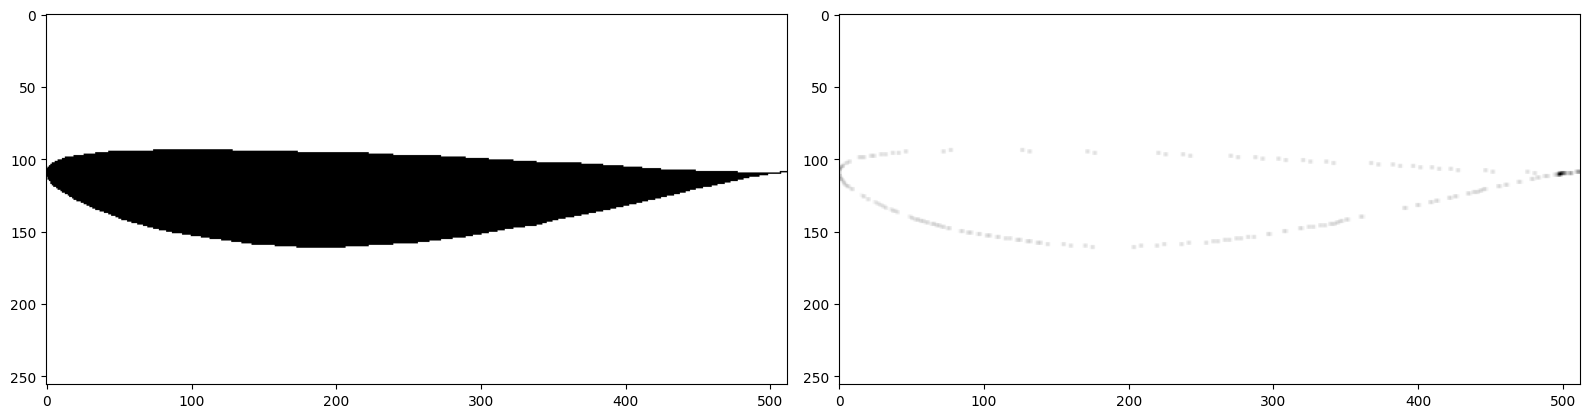

In [74]:
n = 0
fig = plt.figure(figsize = (16, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(results_shape[n], cmap = 'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(curvatures[n], cmap = 'gray_r')
plt.tight_layout()

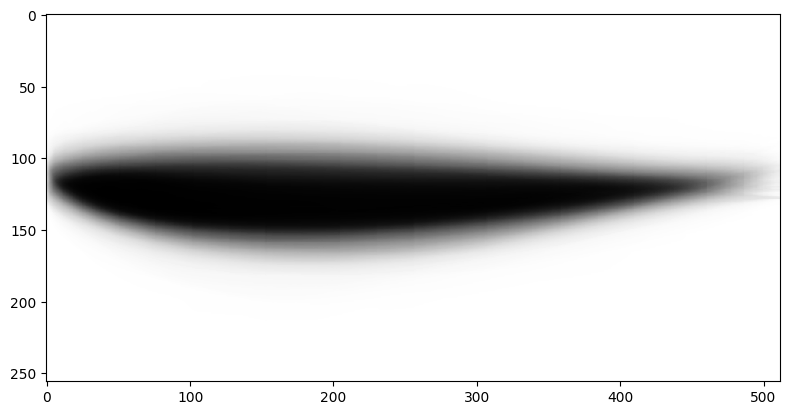

In [75]:
avg_airfoil = np.mean(results_shape, axis = 0)
plt.figure(figsize = (8, 6))
plt.imshow(avg_airfoil, cmap='gray')
plt.tight_layout()

In [77]:
features = ['combined_image', 'params']

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['target'],
    test_size = 0.2,
    random_state = 42,
    shuffle = True
)

In [30]:
y_train = np.array([x for x in y_train])
y_test = np.array([x for x in y_test])

In [151]:
images_train = X_train['combined_image'].values
params_train = X_train['params'].values.astype('float32')

images_test = X_test['combined_image'].values
params_test = X_test['params'].values.astype('float32')

KeyError: 'combined_image'

In [150]:
params_train[0].dtype

dtype('float64')

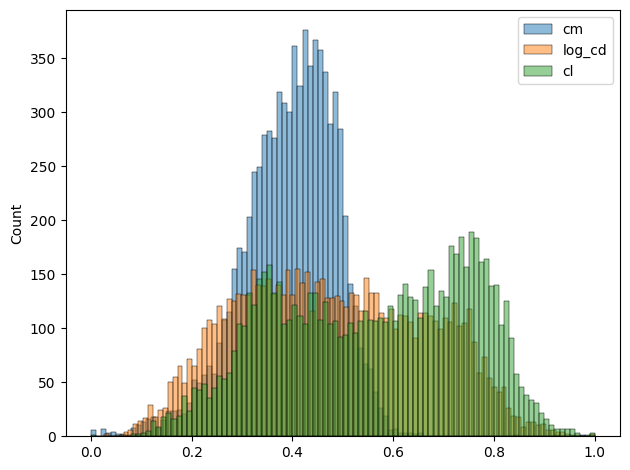

In [80]:
import seaborn as sns

sns.histplot(y_train[:, 2], label = 'cm', bins=100, alpha=0.5)
sns.histplot(y_train[:, 0], label = 'log_cd', bins=100, alpha=0.5)
sns.histplot(y_train[:, 1], label = 'cl', bins=100, alpha=0.5)
plt.legend()
plt.tight_layout()

In [81]:
from tensorflow.random import set_seed

from tensorflow.keras import backend, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    LeakyReLU,
    ReLU,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    Concatenate,
)

In [82]:
pip install -q keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [93]:
def build_model(hp):

    normalization_conv = hp.Choice("Normalization_conv", ["yes", "no"])
    normalization_dense = hp.Choice("Normalization_dense", ["yes", "no"])

    dropout_conv = hp.Choice("dropout_conv", ["yes", "no"])
    dropout_dense = hp.Choice("dropout_dense", ["yes", "no"])

    rate_dropout_conv = hp.Float(
        "rate_dropout_conv", 0.1, 0.3, step = 0.1, default = 0.3
    )
    rate_dropout_dense = hp.Float(
        "rate_dropout_dense", 0.1, 0.3, step = 0.1, default = 0.3
    )

    # CNN branch
    cnn_input = Input(shape=(256, 512, 2))
    x = cnn_input

    for i in range(hp.Int("conv_layers", 2, 3)):
        x = Conv2D(
            filters=hp.Int(
                "filters_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            kernel_size=hp.Int("kernel_size_" + str(i), 2, 4, step = 1),
            activation="relu",
            padding="same"
        )(x)

        x = MaxPooling2D()(x)

        if dropout_conv == "yes":
            x = Dropout(rate = rate_dropout_conv)(x)

        if normalization_conv == "yes":
            x = BatchNormalization()(x)

    cnn_output = Flatten()(x)

    # ANN branch
    ann_input = Input(shape=(2,))
    y = ann_input

    for i in range(hp.Int("dense_layers", 1, 3)):
        ann_output = Dense(
            units = hp.Int(
                "ann_neurons_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            activation = "relu",
        )(y)

    # Combine the outputs
    combined_inputs = Concatenate()([cnn_output, ann_output])

    for i in range(hp.Int("dense_layers", 1, 3)):
        combined_output = Dense(
            units = hp.Int(
                "combined_neurons_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            activation = "relu",
        )(combined_inputs)

        if dropout_dense == "yes":
            x = Dropout(rate=rate_dropout_dense)(x)

        if normalization_dense == "yes":
            x = BatchNormalization()(x)

    combined_output = Dense(units=3)(combined_output)

    # Create the model
    combined_model = Model(
        inputs = [cnn_input, ann_input],
        outputs = combined_output,
        name = "Combined_model"
    )


    # Compile the model
    combined_model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=0.0005),
        metrics=['mae']
    )

    return combined_model

In [110]:
import keras_tuner as kt

tuner = kt.Hyperband(
    hypermodel = build_model,
    objective = "val_loss",
    max_epochs = 10,
    directory = PROJECT_PATH,
    project_name = "tuner",
    overwrite = True
)

tuner.search(
    [images_train, params_train],
    y_train,
    epochs = 10,
    batch_size = 32,
    shuffle = True,
    validation_split = 0.2,
)

best_model = tuner.get_best_models()[0]
best_model.summary()
best_model.save(ML_PATH / "best_model.keras")

Trial 2 Complete [00h 00m 00s]

Best val_loss So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
no                |yes               |Normalization_conv
yes               |no                |Normalization_dense
no                |no                |dropout_conv
yes               |yes               |dropout_dense
0.2               |0.2               |rate_dropout_conv
0.2               |0.1               |rate_dropout_dense
2                 |3                 |conv_layers
64                |32                |filters_0
3                 |4                 |kernel_size_0
64                |32                |filters_1
4                 |2                 |kernel_size_1
2                 |1                 |dense_layers
32                |32                |ann_neurons_0
64                |32                |combined_neurons_0
32                |32                |filters_2
4                 |2                 |ke

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/eng

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/constant_op.py", line 103, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).


In [ ]:
best_model = load_model(ML_PATH / "best_model.keras")
best_model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.0005),
    metrics=['mae']
)

history = best_model.fit(
    [X_train_CNN, X_train_ANN],
    y_train_array,
    epochs = 100,
    batch_size = 32,
    callbacks=checkpoint(ML_PATH / f"weights_tuned_model.h5", patience = 3),
    validation_split = 0.2,
    shuffle = True,
    verbose = 1,
)

Epoch 1/100
200/200 [==============================] - 13s 56ms/step - loss: 0.0041 - mae: 0.0476 - val_loss: 0.0046 - val_mae: 0.0502
Epoch 2/100
  1/200 [..............................] - ETA: 8s - loss: 0.0029 - mae: 0.0408

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 11s 53ms/step - loss: 0.0036 - mae: 0.0446 - val_loss: 0.0043 - val_mae: 0.0471
Epoch 3/100
200/200 [==============================] - 10s 52ms/step - loss: 0.0032 - mae: 0.0424 - val_loss: 0.0043 - val_mae: 0.0479
Epoch 4/100
200/200 [==============================] - 10s 52ms/step - loss: 0.0031 - mae: 0.0410 - val_loss: 0.0043 - val_mae: 0.0472
Epoch 5/100
200/200 [==============================] - 10s 51ms/step - loss: 0.0029 - mae: 0.0395 - val_loss: 0.0043 - val_mae: 0.0476


In [ ]:
best_model.evaluate([X_test_CNN, X_test_ANN], y_test_array)

63/63 [==============================] - 1s 22ms/step - loss: 0.0042 - mae: 0.0473


[0.004161484073847532, 0.04732700437307358]